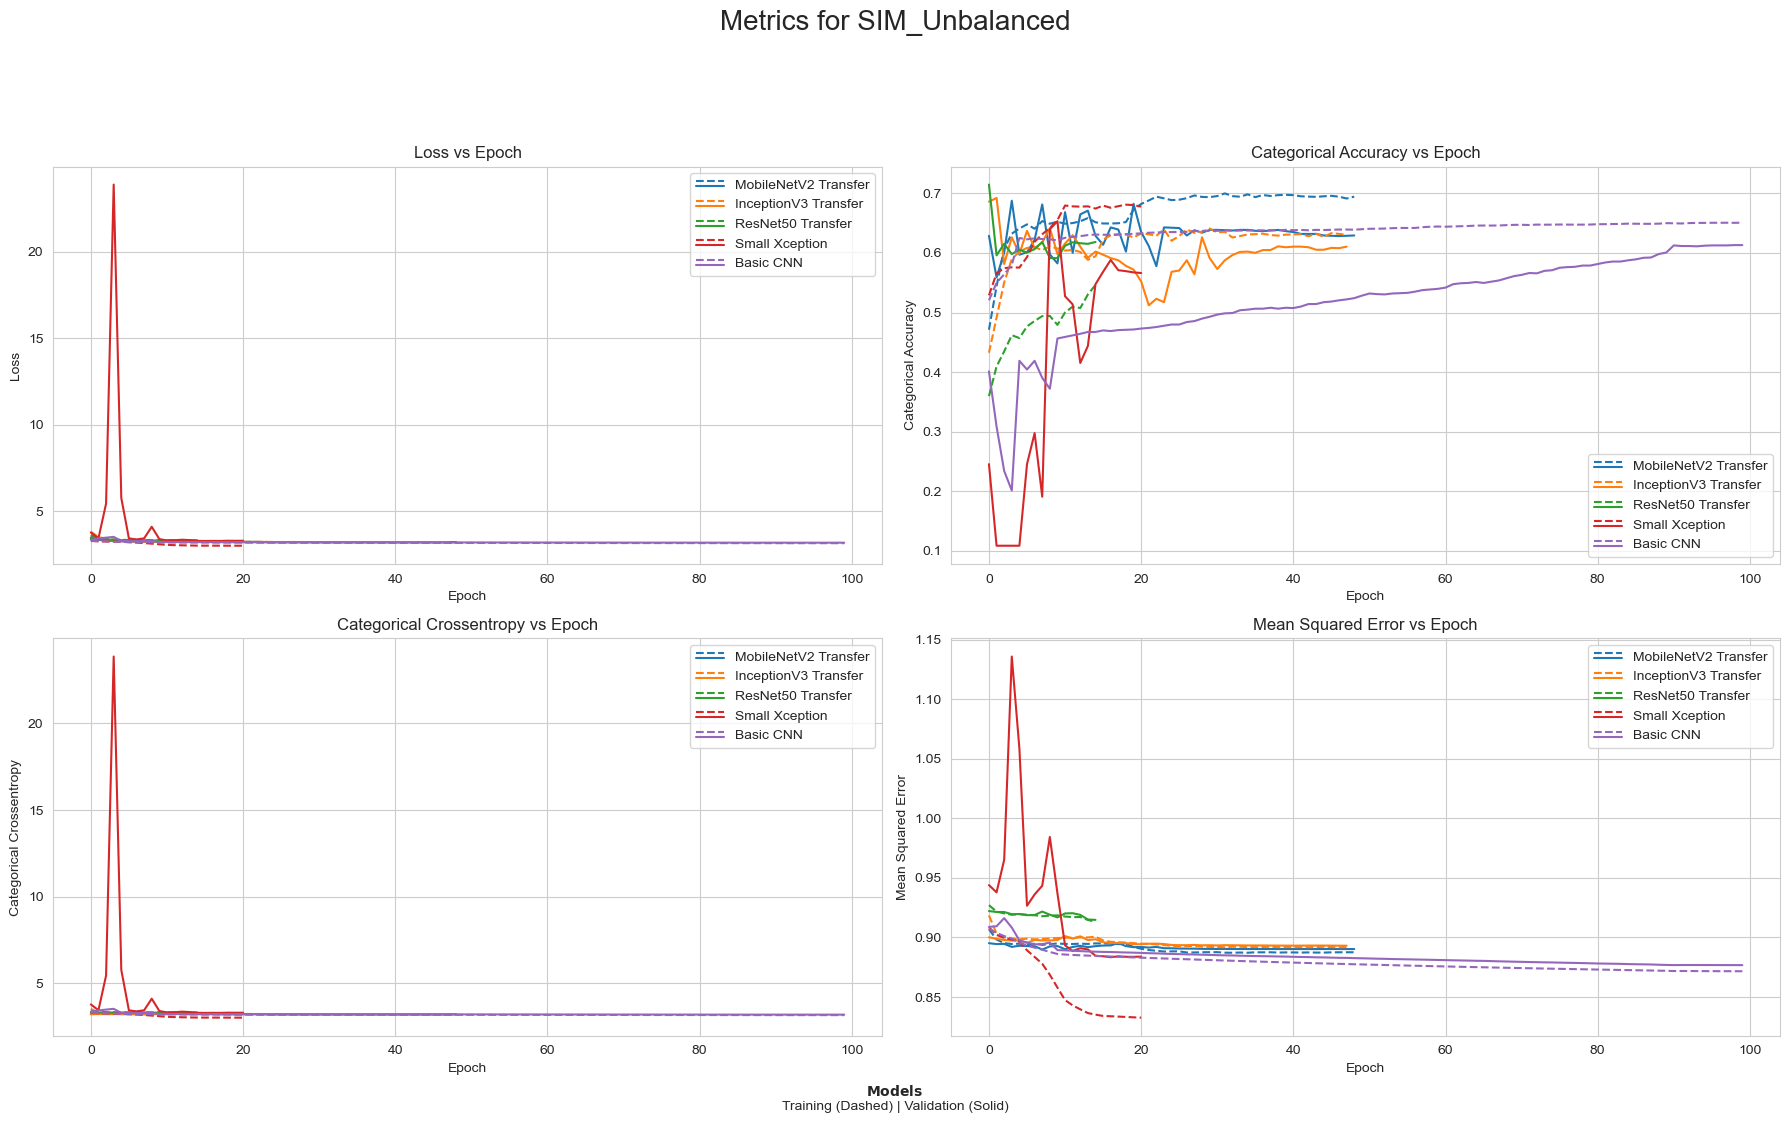

'Plots/SIM_Unbalanced\\Metrics_vs_Epoch.png'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.legend_handler import HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle, xdescent, (2*i + 1)*height_y, width, 2*height, fontsize, trans)
            leglines.extend(legline)
        return leglines

def get_dataframes_from_excel(xls):
    """Load DataFrames from the Excel file."""
    model_names = xls.sheet_names
    return {model_name: pd.read_excel(xls, model_name) for model_name in model_names}

def plot_metrics(ax, dfs, metric, readable_metric, color_dict):
    """Plot metrics for all models on a single graph."""
    for model_name, cleaned_name in zip(dfs.keys(), color_dict.keys()):
        epochs = dfs[model_name]['epoch']
        ax.plot(epochs, dfs[model_name][f'{metric}'], '--', color=color_dict[cleaned_name], label=f"{cleaned_name}") #Training
        ax.plot(epochs, dfs[model_name][f'val_{metric}'], '-', color=color_dict[cleaned_name], label=f"{cleaned_name}") #Validation
    ax.set_title(f"{readable_metric} vs Epoch")
    ax.set_xlabel('Epoch')
    ax.set_ylabel(readable_metric)
    
model_name_mapping = {
    "mobilenetv2": "MobileNetV2 Transfer",
    "inceptionv3": "InceptionV3 Transfer",
    "resnet50": "ResNet50 Transfer",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN"
}
def plot_metrics_from_excel(excel_path):
    # Load the Excel file and get DataFrames
    xls = pd.ExcelFile(excel_path)
    model_names = xls.sheet_names
    dfs = get_dataframes_from_excel(xls)
    readable_model_names = [model_name_mapping.get(name, name) for name in model_names]
    
    # Metrics mapping and Seaborn style
    metric_mapping = {
        'loss': 'Loss',
        'categorical_accuracy': 'Categorical Accuracy',
        'categorical_crossentropy': 'Categorical Crossentropy',
        'mean_squared_error': 'Mean Squared Error'
    }
    sns.set_style("whitegrid")
    palette = sns.color_palette("tab10", len(model_names))
    color_dict = {readable_name: palette[i] for i, readable_name in enumerate(readable_model_names)}
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes_flat = axes.ravel()
    for i, (metric, readable_metric) in enumerate(metric_mapping.items()):
        plot_metrics(axes_flat[i], dfs, metric, readable_metric, color_dict)
        # Add legend to each subplot
        handles, labels = axes_flat[i].get_legend_handles_labels()
        new_handles = [(handles[j], handles[j + 1]) for j in range(0, len(handles), 2)]
        axes_flat[i].legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()})
    
    # Add main title
    experiment_name = os.path.basename(excel_path).replace(".xlsx", "")
    fig.suptitle(f"Metrics for {experiment_name}", fontsize=20, y=1.08)
    
    # Add informational note below the subplots
    note_text = r"$\bf{Models}$" + "\nTraining (Dashed) | Validation (Solid)"
    fig.text(0.5, -0.02, note_text, ha='center', fontsize=10, transform=fig.transFigure)
    
    fig.tight_layout()
    
    # Save and display
    base_dir = os.path.dirname(excel_path)
    output_dir = os.path.join(base_dir, f"Plots/{experiment_name}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    save_path = os.path.join(output_dir, "Metrics_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    return save_path

# Mocking the actual plot as the excel_path is not available
excel_path = 'SIM_Unbalanced.xlsx'
improved_save_path = plot_metrics_from_excel(excel_path)
improved_save_path


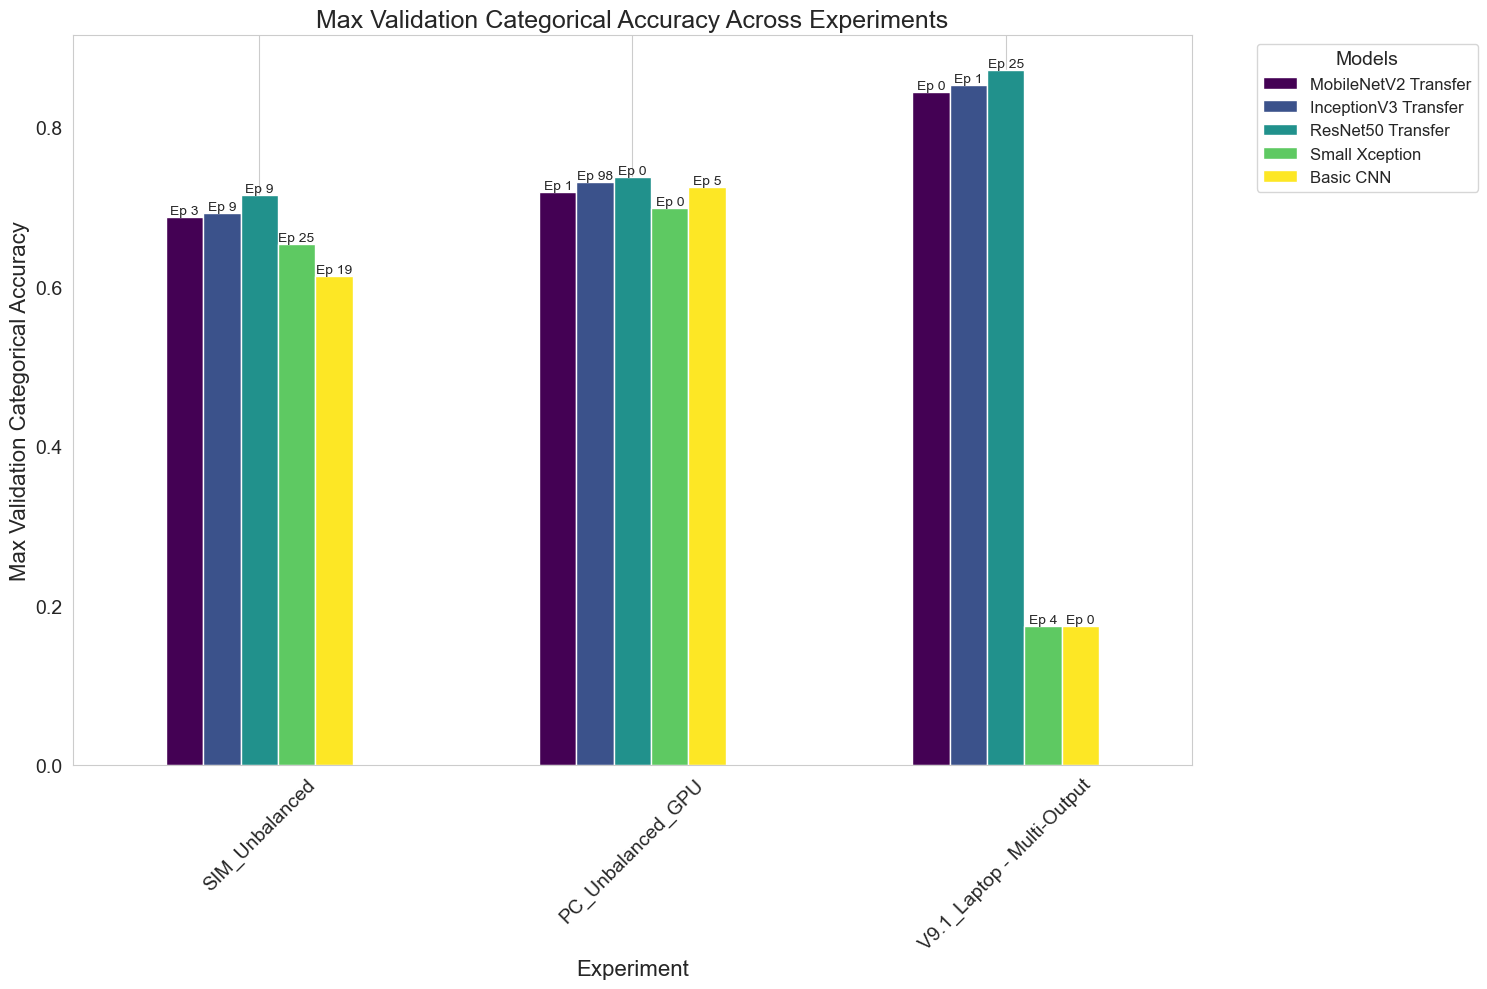

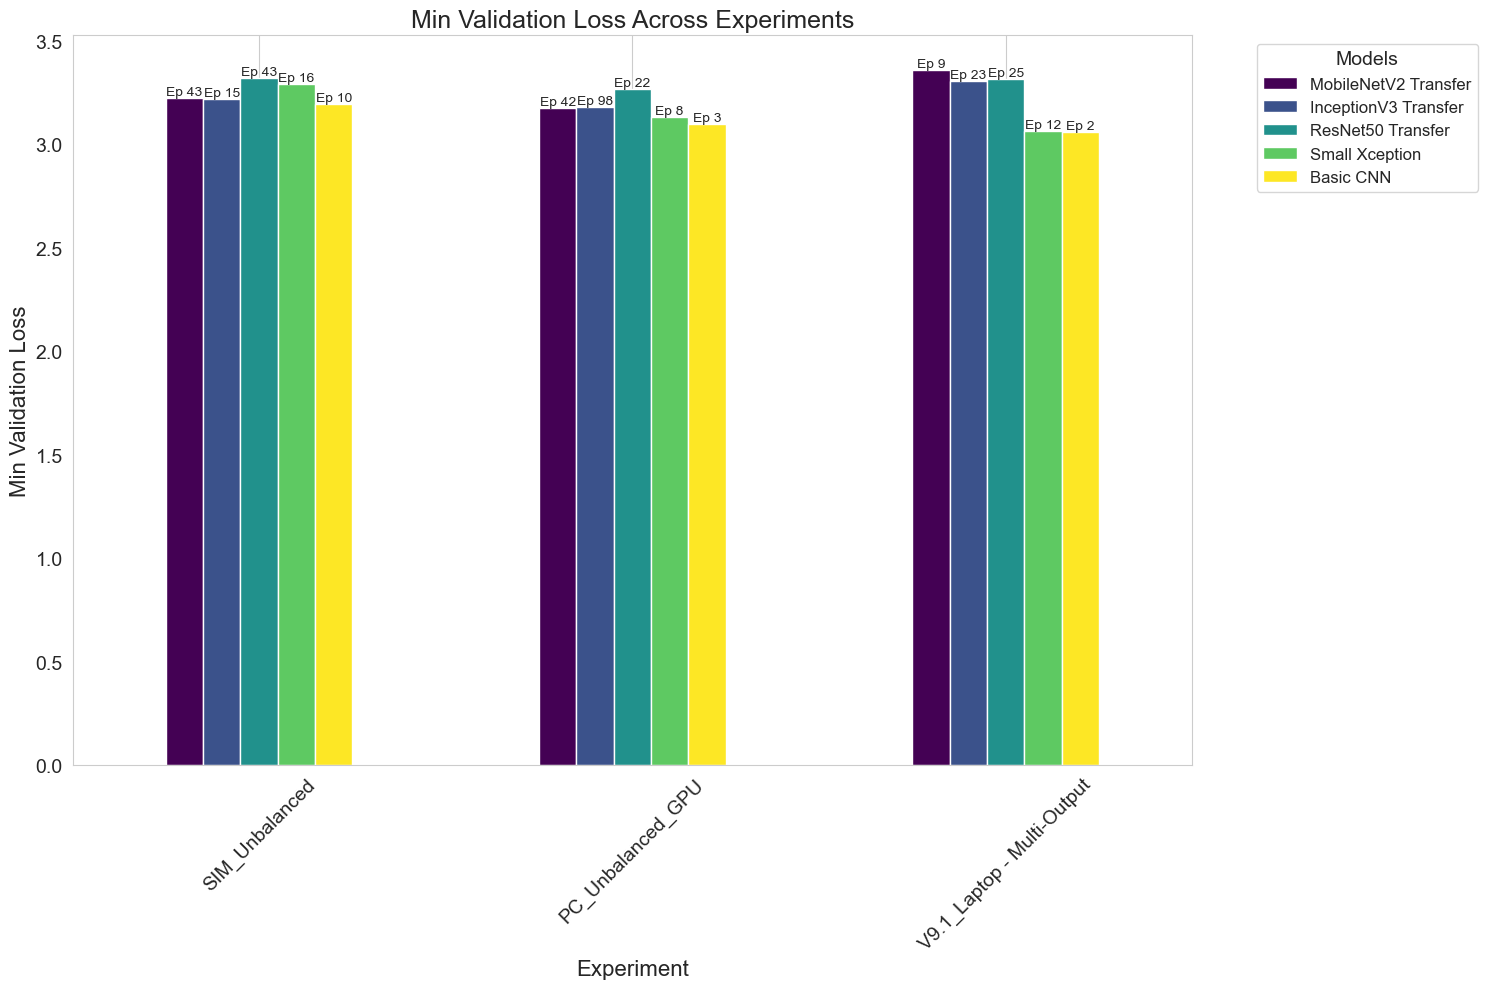

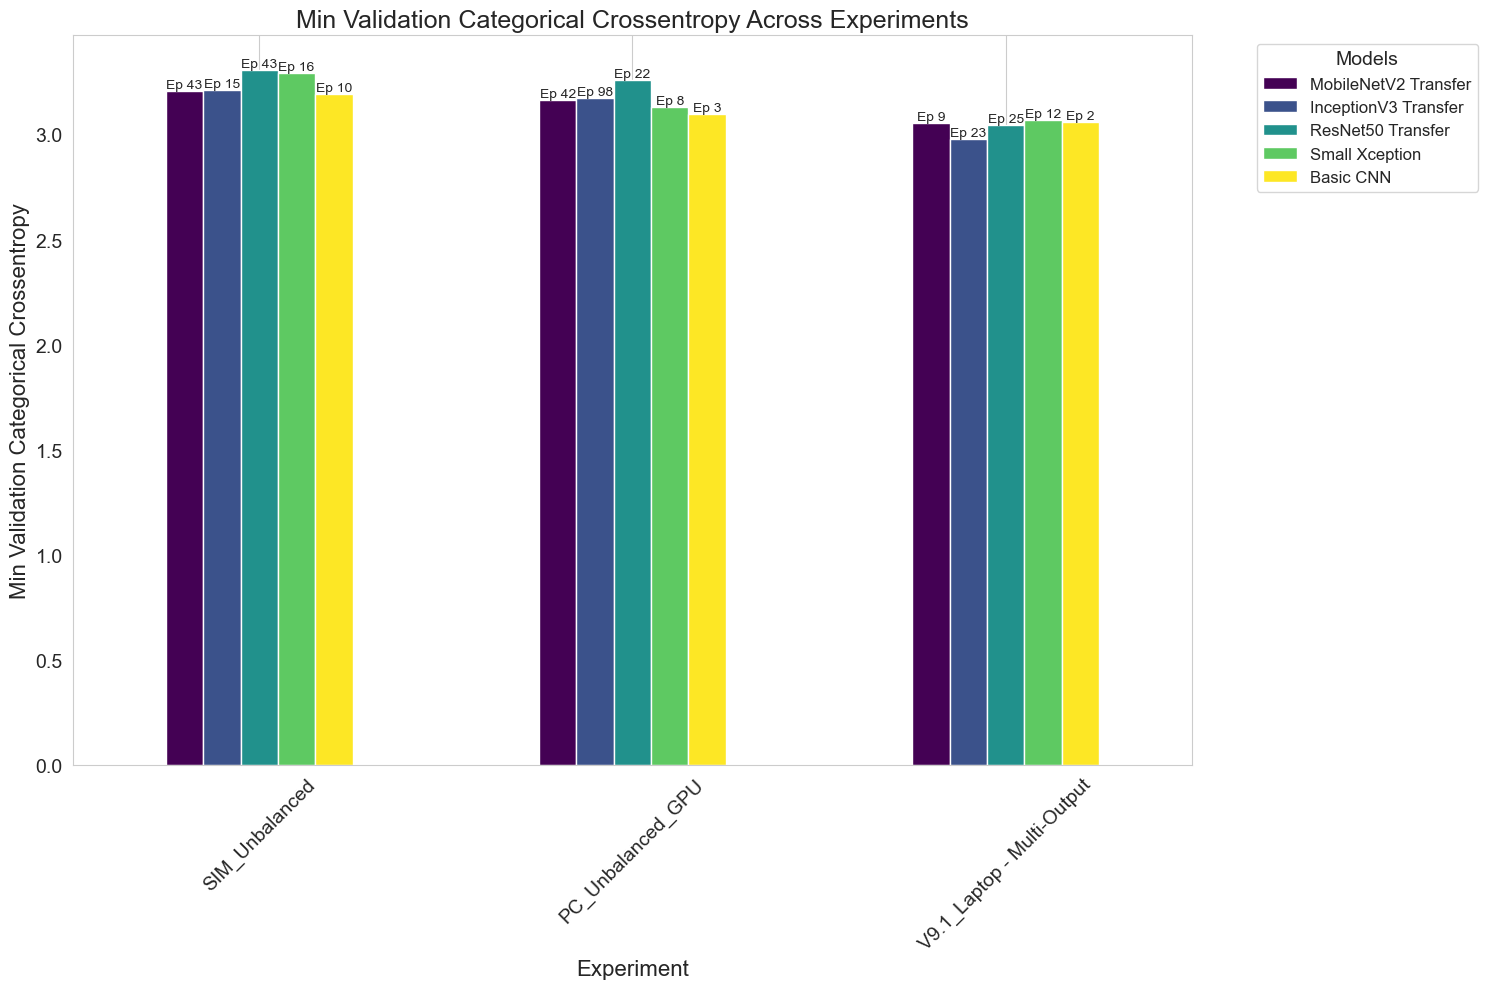

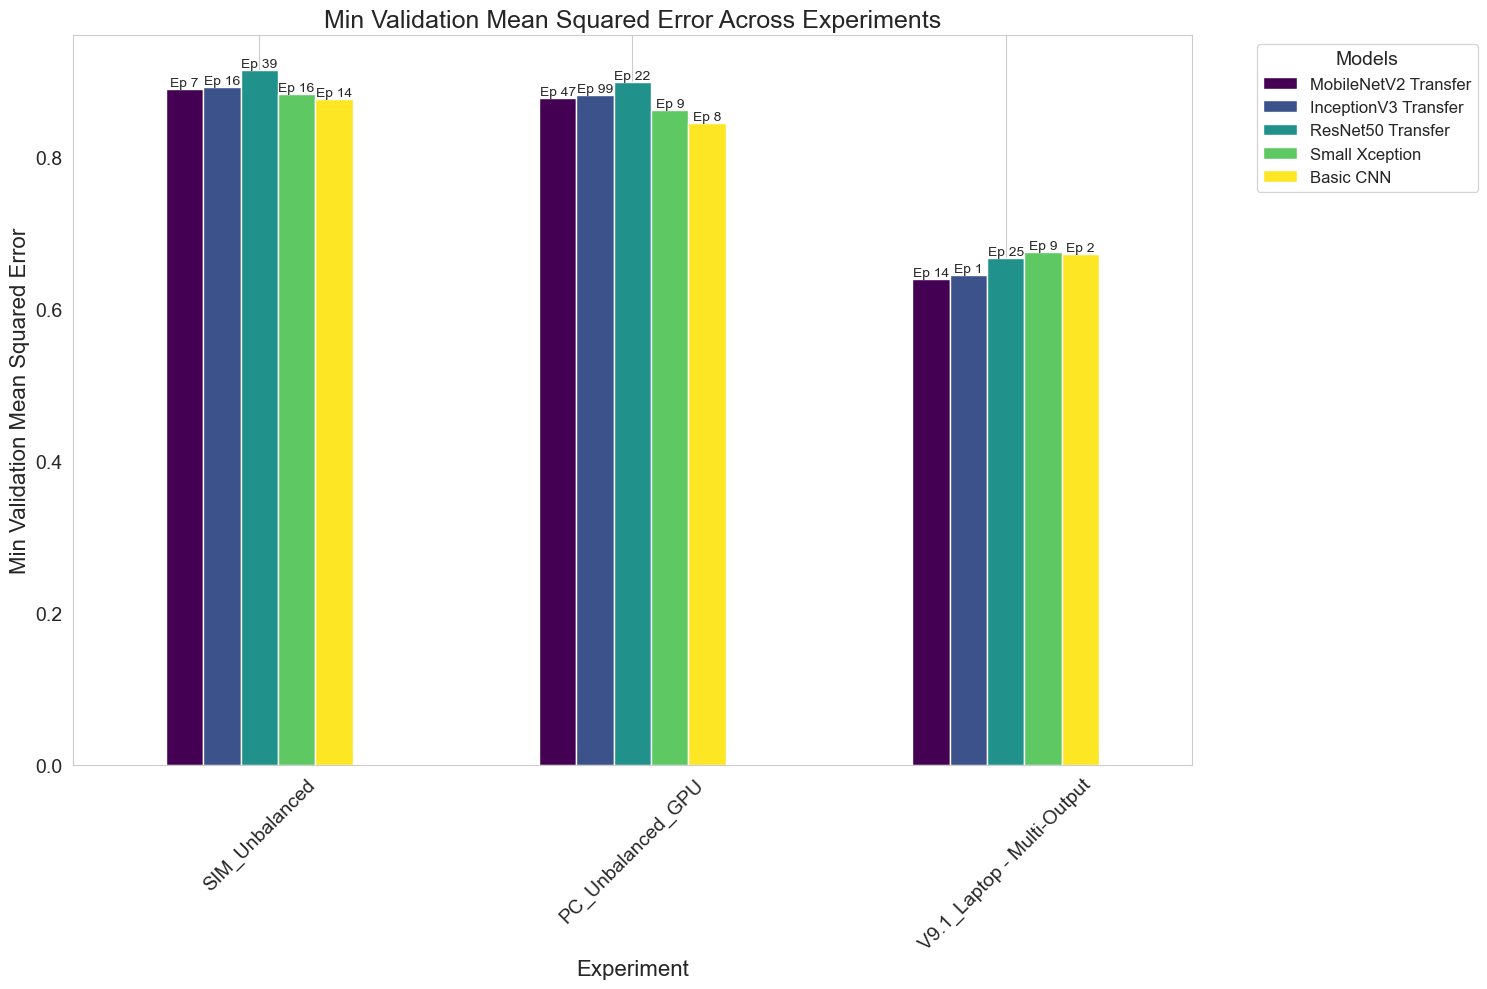

In [3]:
def extract_key_metrics_updated(excel_path):
    """Extract key metrics from the provided Excel file without using determine_engine."""
    metrics_data = {}
    
    # Load the Excel file and get DataFrames
    xls = pd.ExcelFile(excel_path, engine="openpyxl")
    dfs = get_dataframes_from_excel(xls)
    
    for model_name, df in dfs.items():
        metrics_data[model_name] = {
            "Min Validation Loss": df["val_loss"].min(),
            "Epoch at Min Validation Loss": df["epoch"].iloc[df["val_loss"].idxmin()],
            "Max Validation Categorical Accuracy": df["val_categorical_accuracy"].max(),
            "Epoch at Max Validation Categorical Accuracy": df["epoch"].iloc[df["val_categorical_accuracy"].idxmax()],
            "Min Validation Categorical Crossentropy": df["val_categorical_crossentropy"].min(),
            "Epoch at Min Validation Categorical Crossentropy": df["epoch"].iloc[df["val_categorical_crossentropy"].idxmin()],
            "Min Validation Mean Squared Error": df["val_mean_squared_error"].min(),
            "Epoch at Min Validation Mean Squared Error": df["epoch"].iloc[df["val_mean_squared_error"].idxmin()]
        }
    return metrics_data


def visualize_metric_comparison_with_mapping_annotated(file_paths, name_mapping, metric_key, metric_title, epoch_key):
    """Visualize a specific metric across experiments using a name mapping and annotate bars with epoch numbers."""
    metric_data = {}
    epoch_data = {}
    
    # Extract specific metric and epoch data
    for excel_path in file_paths:
        experiment_name = os.path.basename(excel_path).replace(".xlsx", "")
        metrics = extract_key_metrics_updated(excel_path)
        
        # Use the model_name_mapping to rename models
        mapped_metric_values = {name_mapping.get(model, model): data[metric_key] for model, data in metrics.items()}
        mapped_epoch_values = {name_mapping.get(model, model): data[epoch_key] for model, data in metrics.items()}
        
        metric_data[experiment_name] = mapped_metric_values
        epoch_data[experiment_name] = mapped_epoch_values
    
    # Convert to DataFrame for easy plotting
    metric_df = pd.DataFrame(metric_data).transpose()
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    ax = metric_df.plot(kind="bar", ax=plt.gca(), colormap="viridis")
    plt.title(metric_title, fontsize=18)
    plt.ylabel(metric_key, fontsize=16)
    plt.xlabel("Experiment", fontsize=16)
    plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    ax.grid(axis='y')
    
    # Annotate bars with epoch numbers
    for idx, rect in enumerate(ax.patches):
        experiment_idx = idx // len(metric_df.columns)
        model_idx = idx % len(metric_df.columns)
        experiment_name = metric_df.index[experiment_idx]
        model_name = metric_df.columns[model_idx]
        epoch_value = epoch_data[experiment_name][model_name]
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), f'Ep {epoch_value}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


# Visualize all the key metrics with annotations
metric_visualization_keys_with_epochs = [
    ("Max Validation Categorical Accuracy", "Max Validation Categorical Accuracy Across Experiments", "Epoch at Max Validation Categorical Accuracy"),
    ("Min Validation Loss", "Min Validation Loss Across Experiments", "Epoch at Min Validation Loss"),
    ("Min Validation Categorical Crossentropy", "Min Validation Categorical Crossentropy Across Experiments", "Epoch at Min Validation Categorical Crossentropy"),
    ("Min Validation Mean Squared Error", "Min Validation Mean Squared Error Across Experiments", "Epoch at Min Validation Mean Squared Error")
]

for metric_key, metric_title, epoch_key in metric_visualization_keys_with_epochs:
    visualize_metric_comparison_with_mapping_annotated(
        ["SIM_Unbalanced.xlsx", "PC_Unbalanced_GPU.xlsx", "V9.1_Laptop - Multi-Output.xlsx"],
        model_name_mapping,
        metric_key,
        metric_title,
        epoch_key
    )


In [4]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def make_confusion_matrix_multi_output(y_true, y_preds, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels for multi-output models.

    Args:
    y_true: List of arrays of truth labels (must be same shape as y_preds).
    y_preds: List of arrays of predicted labels (must be same shape as y_true).
    classes: List of arrays of class labels (e.g. string form). If `None`, integer labels are used.
    ... (other arguments as before)

    Returns:
    A list of labelled confusion matrix plots comparing y_true and y_preds for each output.
    """
    # Check if y_true and y_preds are lists, if not, convert them to lists (for single-output compatibility)
    if not isinstance(y_true, list):
        y_true = [y_true]
    if not isinstance(y_preds, list):
        y_preds = [y_preds]
    
    for i, (true, pred) in enumerate(zip(y_true, y_preds)):
        print(f"Output {i + 1}:")
        make_confusion_matrix(true, pred, classes[i] if classes else None, figsize, text_size, norm, savefig)
        plt.show()

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # (The function content remains the same as you provided)

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig(f"confusion_matrix_output_{i + 1}.png")



In [5]:
import os
from tensorflow.keras.models import load_model

def get_best_model_filename(directory):
    """Identify the best model filename based on the minimum validation loss from the directory."""
    model_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
    if not model_files:
        print(f"No model files found in {directory}")
        return None
    return min(model_files, key=lambda x: float(x.split('val_loss_')[1].split('_')[0]))

def load_best_model(directory):
    """Loads the best model from the specified directory."""
    best_model_file = get_best_model_filename(directory)
    if not best_model_file:
        return None
    best_model_path = os.path.join(directory, best_model_file)
    # return load_model(best_model_path)
    return load_model(best_model_path, compile=False)

def get_label_directories(experiment_directory):
    """Determine label directories or just model directories in the experiment directory."""
    first_level_dirs = [os.path.join(experiment_directory, d) for d in os.listdir(experiment_directory) 
                        if os.path.isdir(os.path.join(experiment_directory, d))]
    if any('mobilenetv2' in dir_name for dir_name in first_level_dirs):
        return [experiment_directory]
    return first_level_dirs

def load_all_best_models(experiment_directory):
    """Load the best model for each model type within the experiment directory."""
    best_models = {}
    label_dirs = get_label_directories(experiment_directory)
    for label_dir in label_dirs:
        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            best_model = load_best_model(model_dir)
            if best_model:
                key_name = f"{os.path.basename(label_dir)}_{model_name}"
                best_models[key_name] = best_model
    return best_models

# Example Usage
experiment_directory = "SIM_Unbalanced"
all_best_models = load_all_best_models(experiment_directory)
print(all_best_models.keys())  # This will display the keys of the loaded models.


dict_keys(['SIM_Unbalanced_mobilenetv2', 'SIM_Unbalanced_inceptionv3', 'SIM_Unbalanced_resnet50', 'SIM_Unbalanced_small_xception', 'SIM_Unbalanced_basic_cnn'])


In [6]:
def extract_labels_from_dataset(dataset, problem_type):
    """
    Extract labels from a TensorFlow dataset based on the problem type.
    
    Args:
    - dataset (tf.data.Dataset): The TensorFlow dataset to extract labels from.
    - problem_type (str): The type of problem ('Multi-Output', 'Multi-Class', or 'Binary').
    
    Returns:
    - numpy array or dict: If 'Multi-Output', returns a numpy array with shape (num_samples, num_outputs).
                           If 'Multi-Class' or 'Binary', returns a dictionary with label types as keys and 
                           arrays of labels as values.
    """
    
    if problem_type == 'Multi-Output':
        labels_list = [labels for _, labels in dataset]
        return np.array(labels_list).squeeze()

    elif problem_type in ['Multi-Class', 'Binary']:
        labels_dict = {}
        for label_type in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
            label_data = []
            for _, labels in dataset[label_type]:
                label_data.extend(labels.numpy())
            labels_dict[label_type] = np.array(label_data)
        return labels_dict

    else:
        print(f"Unknown problem type: {problem_type}")
        return None

# Usage
problem_type = config['Experiment']['PROBLEM_TYPE']
test_labels = extract_labels_from_dataset(test_dataset, problem_type)

# Choose a specific model (replace 'specific_model_name' with the actual model name you're interested in)
model_name = 'specific_model_name'
model = all_best_models[model_name]

if not model:
    print(f"No model found for {model_name}")
    exit()

# 1. Predict on the test data
predictions = model.predict(test_dataset)


# 2. Get true labels and predictions for each output
# Assuming test_labels is a list where each item is an array of true labels for a given output
true_labels = [test_labels[i] for i in range(len(predictions))]
predicted_labels = [np.argmax(predictions[i], axis=1) for i in range(len(predictions))]

# List of class names for each output, assuming they are the same for all outputs in this example
classes_list = [list(range(3)) for _ in range(len(predictions))]

# 3. Generate confusion matrices
make_confusion_matrix_multi_output(true_labels, predicted_labels, classes_list)


NameError: name 'config' is not defined